## Importar todas las librerías

In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold, MELODIC, FilterRegressor)
#from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node, Function
import nibabel as nib

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Parametros del conjunto

In [2]:
#Direcciones de trabajo
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# Etiquetas de los sujetoos
subject_list = ['01']#, '02', '03', '04', '05', '06', '07', '08', '09', '10']

# Sesiones 
task_list = ['rest']

# Ancho del suavizado
fwhm = [4, 8]

#Abrir achiivo json para sacar TR
with open('/data/ds000133/sub-01/ses-pre/func/sub-01_ses-pre_task-rest_run-01_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']
#TR=2.0

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

In [3]:
ANAT='/data/ds000133/sub-01/ses-pre/anat/sub-01_ses-pre_T1w.nii.gz'
FUNC='/data/ds000133/sub-01/ses-pre/func/sub-01_ses-pre_task-rest_run-01_bold.nii.gz'

print(nib.load(ANAT).shape)
print(nib.load(FUNC).shape)
print(TR)

(256, 256, 180)
(64, 64, 30, 145)
1.67065


### Funciones propias

In [4]:
def smoothNi(PATH_GZ, fwhm):
    from nilearn import image
    import os

    F_smooth=image.smooth_img(PATH_GZ,fwhm=fwhm)
    OutFile='s'+PATH_GZ[PATH_GZ.rfind('/')+1:]
    F_smooth.to_filename(OutFile)
    
    out_file=os.path.abspath(OutFile)
    return out_file

def filtered(PATH_GZ):
    from nilearn.input_data import NiftiMasker
    from nilearn.signal import butterworth
    import os
        
    masker = NiftiMasker()   
    signal = masker.fit_transform(PATH_GZ)    
    X_filtered = butterworth(signals=signal, sampling_rate=1./TR, high_pass=0.01, copy=True)
    fmri_filtered = masker.inverse_transform(X_filtered)
    OutFile='f'+PATH_GZ[PATH_GZ.rfind('/')+1:]
    fmri_filtered.to_filename(OutFile)
    
    out_file=os.path.abspath(OutFile)
    return out_file

def SelecICA(in_dir):
    import glob
    mec_mix=glob.glob(in_dir+'/*_mix')[0]    
    noise=[1, 2, 3]
    return mec_mix, noise

### Nodos del preproceso principal

In [5]:
# Eliminar primeros volumenes
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# Correccion de movimiento
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# Corrección de tiempo de corte
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

smooth=Node(Function(input_names=['PATH_GZ', 'fwhm'],
                     output_names=['out_file'],
                     function=smoothNi),
            name='smooth')

smooth.iterables = ("fwhm", fwhm)

Filter=Node(Function(input_names=['PATH_GZ'],
                     output_names=['out_file'],
                     function=filtered),
            name='filter')

# Deteccion de Artefa- determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

### Nodos del coregistro

In [6]:
# Eliminar craneo
bet_anat = Node(BET(frac=0.5,
                    in_file = ANAT,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# Segmentacion LCR, MG y MB
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")

# Selecionar el archivo de MB desde la salida de la segmentacion
def get_wm(files):
    return files[-1]

# Umbralizacion - Imagen de probabilidad de la MB umbralizada
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# Pre realineacion de la imagenes funcionales a la imagenes anatomicas
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration de la imagen funcional a la imagen anatomica con BBR (
# BBR (Basado en los límintes de la materia blanca)
# El corregistro se centra en corregir el movimiento entre sus exploraciones anatómicas
# y sus exploraciones funcionales
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Aplicar la transformacion del coregistro a la imagen funcional
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Aplicar la transformacion del coregistro a los archivos promedios
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

In [7]:
# Crear el flujo de trabajo del coregistro
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

In [8]:
# Conectar todos los Nodos del flujo
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                (segmentation, threshold, [(('partial_volume_files', get_wm), 'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

200327-14:58:53,519 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/coregwf/graph.png (graph2use=flat, simple_form=True).


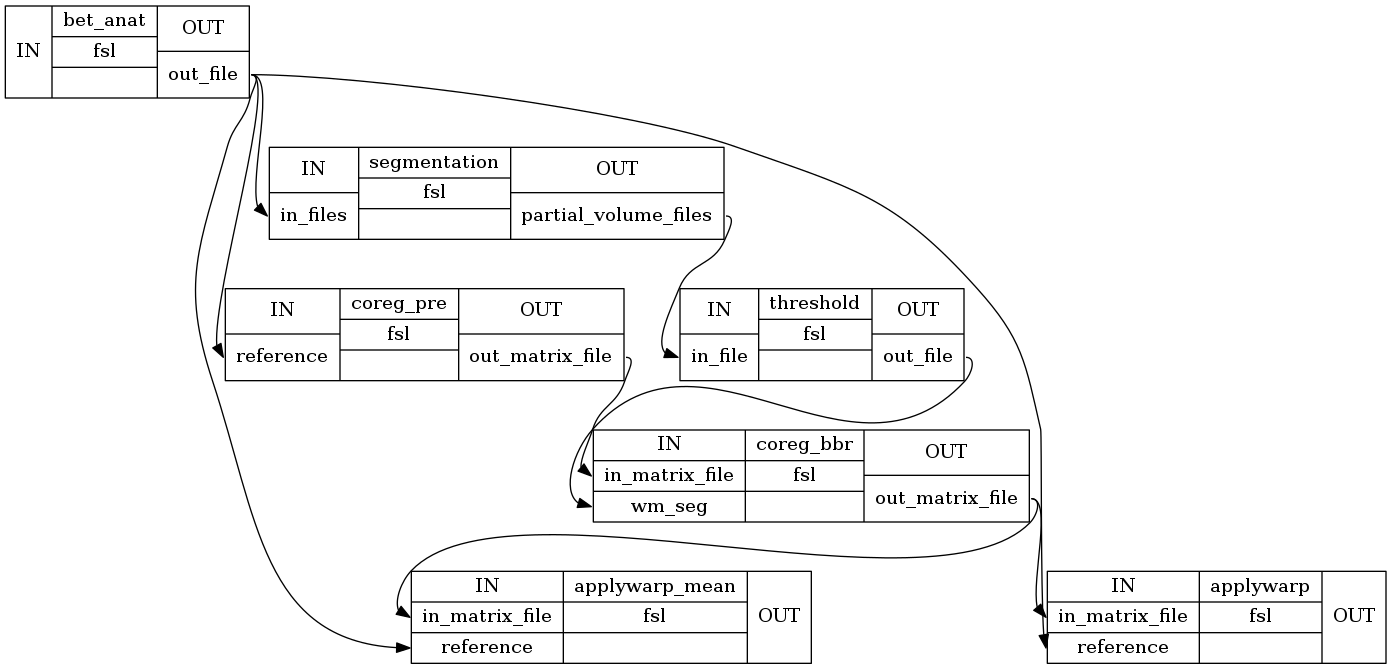

In [9]:
#Visualizar el flujo de trabajo
coregwf.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename="/output/workingdir/coregwf/graph_detailed.png")

### Especificar entradas y salidas del flujo

In [10]:
#Informacion de la fuente: Un nodo para iterar entre todos los suujetos 
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")

#Iteracion entre sujetos y las tareas de los sujetos
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# Estructura de los nombre de los sujetos
anat_file = opj('sub-{subject_id}', 'ses-pre', 'anat','sub-{subject_id}_ses-pre_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'ses-pre', 'func','sub-{subject_id}_ses-pre_task-{task_name}_run-01_bold.nii.gz')

#Archivos anatomicos y funcionales
templates = {'anat': anat_file,
             'func': func_file}

#Nodo de direccion de los sujetos
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/ds000133'),
                   name="selectfiles")

# Datasink - Crear una carpeta de salidad para almacenar las entradas
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
## Los archivos generados tienen esas palabras claves en sus direcciones
## Por lo tanto se cambian esas palabras por las otras para que queden en
## el formato establecido

substitutions = [('_subject_id_', 'sub-'),  #sub-01     Carpeta por sujeto
                 ('_task_name_', '/task-'), #task-rest  Carpeta de tareas
                 ('_fwhm_', 'fwhm-'),       #Variacion en el fwhm
                 ('_roi', ''),              #segunto argumento vacio
                 ('_mcf', ''),              #''
                 ('_st', ''),               #''
                 ('_flirt', ''),            #''
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
#Se buscan subcarpetas para eliminarlas
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]

# Se crean los pares de nombres de "/" a "-"
# Esto permite pasar de un sub caparpeta a un archivo directo
# y se agrega a los pares de sustituciones
substitutions.extend(subjFolders)

# Se indican las sustituciones en los direcciones y nombres al NODO
datasink.inputs.substitutions = substitutions

### Nodos denoising

In [11]:
ICA = Node(MELODIC(report = True, ),
                  name="Descomposition_ICA")

Selec=Node(Function(input_names=['in_dir'],
                    output_names=['melodic_mix', 'Noise'],
                    function=SelecICA),
           name='Selection_files')

D_ICA=Node(FilterRegressor(),
            name='Denoising_ICA')

## Flujo completo

In [12]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir) #Une los caracteres con un /

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),     ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 
                 #(coregwf, smooth, [('applywarp.out_file', 'in_files')]),
                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),
                 (coregwf, smooth, [('applywarp.out_file', 'PATH_GZ')]),
                 (smooth, Filter, [('out_file', 'PATH_GZ')]),
                 
                 
                 
                 
                 #Organizar los datos de salida
                 (Filter, datasink, [('out_file', 'preproc.@Filtered')]), #Nombre del nodo
                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),                 
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),
                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')])
                 ])

200327-14:58:54,586 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


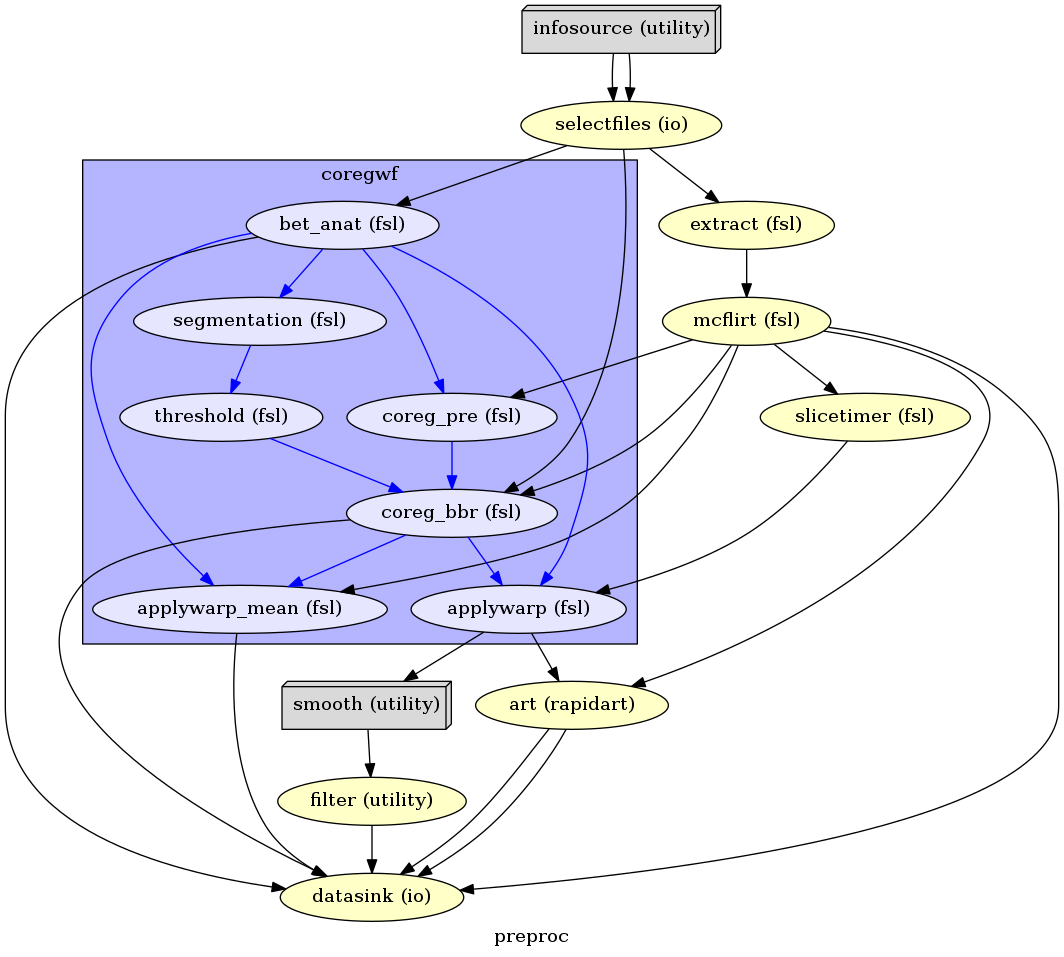

In [13]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

200327-14:58:55,947 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


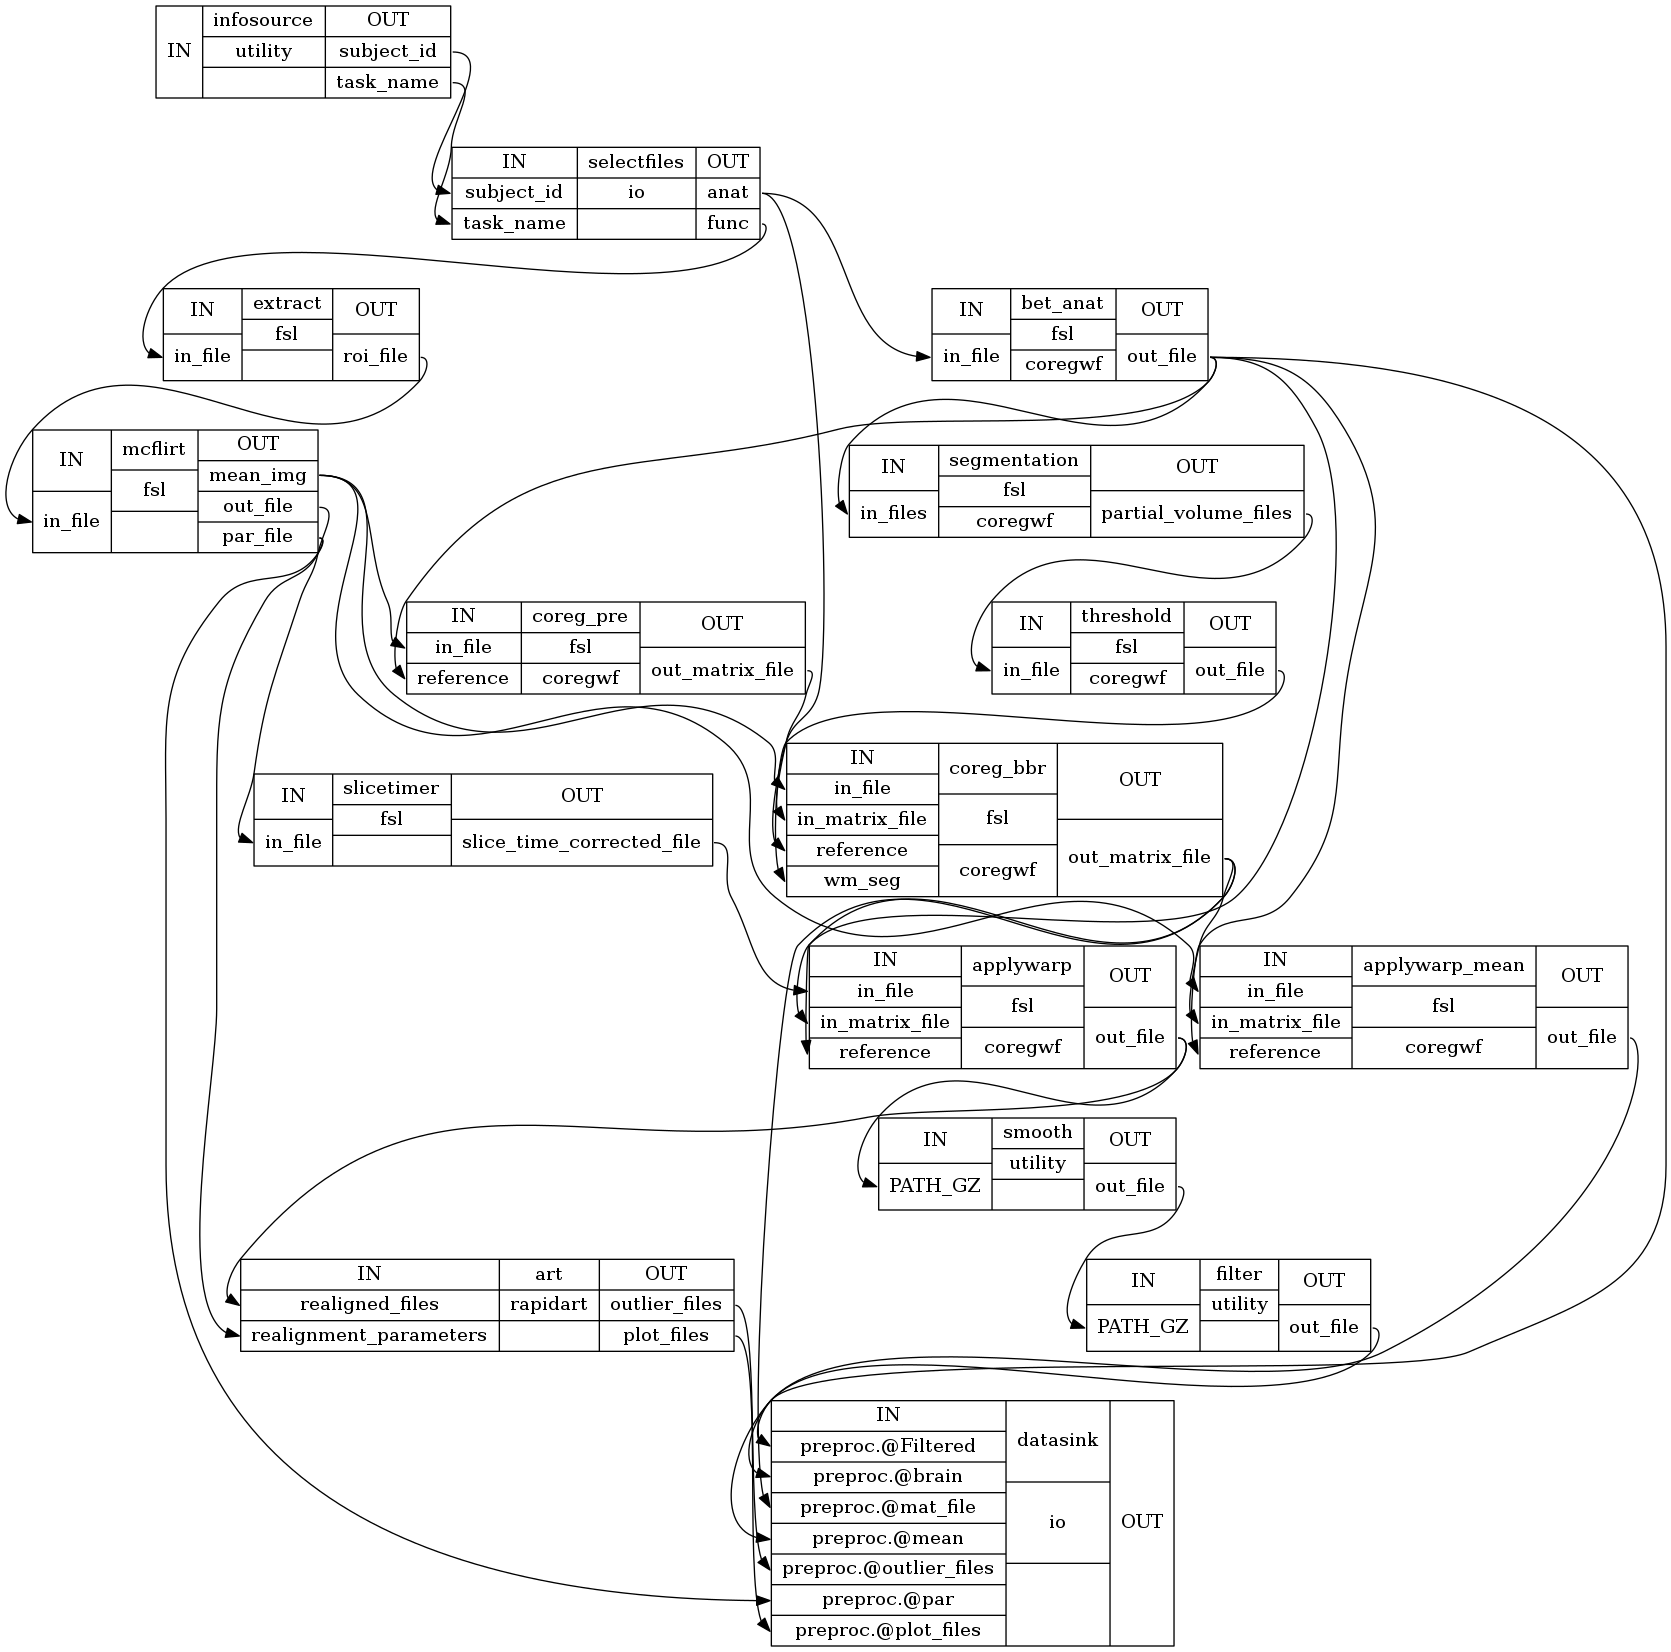

In [14]:
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

In [15]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

200327-14:58:56,204 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
200327-14:58:56,311 nipype.workflow INFO:
	 Running in parallel.
200327-14:58:56,317 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 6.79/6.79, Free processors: 4/4.
200327-14:58:56,470 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_01_task_name_rest/selectfiles".
200327-14:58:56,503 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
200327-14:58:56,528 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
200327-14:58:58,318 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).
200327-14:58:58,322 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 6.79/6.79, Free processors: 4/4.
200327-14:58:58,416 nipype.workflow INFO:
	 [Job 1] Cached (preproc.coregwf.bet_anat).
200327-1

RuntimeError: Workflow did not execute cleanly. Check log for details

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save.

In [ ]:
!tree /output/datasink/preproc

## Visualize results

Let's check the effect of the different smoothing kernels.

In [ ]:
from nilearn import image, plotting
out_path = '/output/datasink/preproc/sub-01/task-rest'

In [ ]:
plotting.plot_epi(
    '/data/ds000133/sub-01/ses-pre/anat/sub-01_ses-pre_T1w.nii.gz',
    title="T1", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

In [ ]:
plotting.plot_epi(opj(out_path, 'sub-01_ses-pre_task-rest_run-01_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

In [ ]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-4_ssub-01_ses-pre_task-rest_run-01_bold.nii')),
                  title="fwhm = 4mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

In [ ]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-8_ssub-01_ses-pre_task-rest_run-01_bold.nii')),
                  title="fwhm = 8mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

Movimiento del sujeto

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
par = np.loadtxt('/output/datasink/preproc/sub-01/task-rest/sub-01_ses-pre_task-rest_run-01_bold.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('Rotación (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('Tiempo (TR)')
axes[1].set_ylabel('Traslacion (mm)');

There seems to be a rather drastic motion around volume 102. Let's check if the outliers detection algorithm was able to pick this up.

In [ ]:
import numpy as np
outlier_ids = np.loadtxt('/output/datasink/preproc/sub-01/task-rest/art.sub-01_ses-pre_task-rest_run-01_bold_outliers.txt')
print('Se detectaron valores atipicos en los volumenes: %s' % outlier_ids)

from IPython.display import SVG
SVG(filename='/output/datasink/preproc/sub-01/task-rest/plot.sub-01_ses-pre_task-rest_run-01_bold.svg')